Goal: We want to analyze range of overlap between source and target populations in feature age such that it ganrantees good performance on OTTEHR

In [1]:
import sys
import getpass
user_id = getpass.getuser()
sys.path.append(f"/home/{user_id}/OTTEHR/")

import matplotlib.pyplot as plt
from mimic_common import *
import numpy as np
import os
import pandas as pd

2024-12-05 12:00:02.893998: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-05 12:00:02.894049: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-05 12:00:02.895295: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-05 12:00:02.902586: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-05 12:00:03.652958: W tensorflow/compiler/tf2

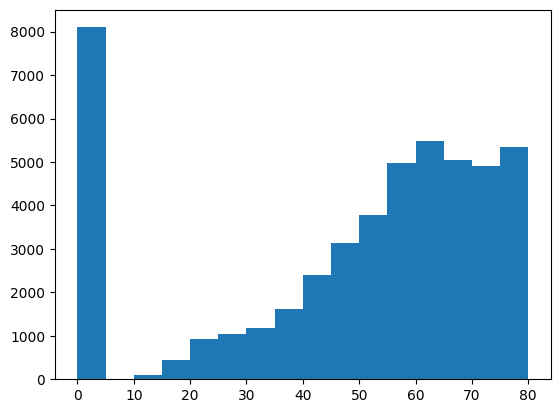

In [2]:
# Visualize age distribution 
mimic_iii_df = pd.read_csv(os.path.join(mimic_output_dir, 'admission_patient_diagnosis_ICD_with_age.csv'), index_col=None, header=0, converters={'ICD codes': literal_eval})

bins = np.arange(0, 81, 5)
plt.hist(mimic_iii_df['age'], bins=bins)
plt.show()

In [4]:
source_range = [50, 70]
target_ranges = [[10, 25], [25, 40], [30, 45], [35, 50], [40, 55], [45, 60], [55, 70]]
group_name = 'age'
trans_metric = 'OT'

for target_range in target_ranges:
    score_path = os.path.join(mimic_output_dir, f"{group_name}_{target_range}_to_{source_range}_{trans_metric}.csv")
    score_df = pd.read_csv(score_path, header=0, index_col=None)
    stat = np.mean(score_df['trans_target_mae'])
    print(f"{target_range}: {stat}")

[10, 25]: 618483.7947318495
[25, 40]: 677309.3692275207
[30, 45]: 692961.7120486015
[35, 50]: 678781.4690809842
[40, 55]: 673893.3571502776
[45, 60]: 632079.3497131944
[55, 70]: 546486.0816574467
